# MSDS 7331 - Case Study 3 - Clasification of e-mail as ham or spam
Daniel Crouthamel

Sophia Wu

Fabio Savorgnan

Bo Yun

# Introduction

In this study, we will be building a classifier to predict busines that will go on bankrupcy. 

# Business Understanding

Business forecasting refers to the tools and techniques used to predict developments in business, such as sales, expenditures, and profits. The purpose of business forecasting is to develop better strategies based on these informed predictions. Past data is collected and analyzed via quantitative or qualitative models so that patterns can be identified and can direct demand planning, financial operations, future production, and marketing operations. 

Therefore we use the busines forescasting principles to predict business that could go on bankrupcy, we will use the data given to us and perform the following process:

Data engeniering, 

Model preparation,

Evaluation and interpretation of the selected model and 
 
Conclusion.

In [1]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import randint as sp_randint

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# Yellowbrick
from yellowbrick.model_selection import FeatureImportances

#Pipeline
from sklearn.pipeline import make_pipeline

# Files
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
from scipy.io import arff



# Data engeniering

This dataset contains financial information from different business. The rows are the business 43405, and the columns are the variables with information from the different business. With the objective to include most of the available data. We decided that missing values less than 10 % we would keep as variables for our mode, because we would impute with the mean for each columns to replace the missing values. We will use the simple imputer. Some columns are skew but the mean and the medium are very close, therefore we decided to replace the missing values with the mean.

So we decided to take out the Attr 21  "Sales (n) / sales (n-1)" because it has 13.5 missing values, also we decide to take out Attr 37 "Profit on operating activities / financial expenses" because it has 43.7 missing values. We believe, especially for Attr 37, that this number of missing values would not be able to replace in a meaningful way with imputation.

We also plan to normalize the data using the robust scaler, we know that because the model that we are using, XGBoster and random forest, the normalization will not affect the performance of the model that much.

The selected model, XGBoost is an effective machine learning model, even on datasets where the class distribution is skewed. Before any modification or tuning is made to the XGBoost algorithm for imbalanced classification, it is important to test the default XGBoost model and establish a baseline in performance. So, our final selected model is XGBoost, and we expect that our model will deal with the unbalanced data given to us in the used dataset. But we will keep in mind the unbalanced data target in the preparation, building and evaluation of our model.

Please see the attached pandas profiles and code describing the process that we just described.


## Load the data and EDA

In [2]:
files = ['data/1year.arff', 'data/2year.arff', 'data/3year.arff', 'data/4year.arff', 'data/5year.arff']


df = pd.DataFrame(arff.loadarff(files[0])[0])

for f in files[1:]:
    data_temp = arff.loadarff(f)
    df_temp = pd.DataFrame(data_temp[0])
    print(df_temp.shape)
    df = df.merge(df_temp,how='outer') 

(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [3]:
print(df.shape)

df.head()

(43405, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [4]:
df.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,43397.000000,43397.000000,43397.000000,43271.000000,4.331600e+04,43397.000000,43397.000000,43311.000000,43396.000000,43397.000000,...,4.340400e+04,4.327800e+04,43398.000000,4.332100e+04,43398.000000,4.125300e+04,43303.000000,4.327800e+04,43271.000000,42593.000000
mean,0.035160,0.590212,0.114431,6.314702,-3.853466e+02,-0.056107,0.093478,12.640779,2.652166,0.626868,...,7.672188e+03,-2.621959e+01,-0.010510,3.002644e+01,1.333288,4.480858e+02,17.033202,1.502328e+03,9.343074,72.788592
std,2.994109,5.842748,5.439429,295.434425,6.124303e+04,7.201326,5.713075,505.894281,62.932732,14.670597,...,7.005310e+04,5.327862e+03,13.674072,5.334454e+03,122.104445,3.234560e+04,553.049406,1.392667e+05,124.177354,2369.339482
min,-463.890000,-430.870000,-479.960000,-0.403110,-1.190300e+07,-508.410000,-517.480000,-141.410000,-3.496000,-479.910000,...,-1.805200e+06,-1.108300e+06,-1667.300000,-1.986900e+02,-327.970000,-1.244000e+01,-12.656000,-2.336500e+06,-1.543200,-10677.000000
25%,0.003429,0.268980,0.021521,1.049500,-4.908000e+01,0.000000,0.005776,0.430275,1.018500,0.295470,...,2.755425e+01,9.348500e-03,0.014649,8.753200e-01,0.000000,5.545500e+00,4.510150,4.214400e+01,3.097650,2.176800
50%,0.049660,0.471900,0.196610,1.569800,-1.034500e+00,0.000000,0.059634,1.070400,1.195350,0.505970,...,1.088350e+03,5.294300e-02,0.119670,9.509600e-01,0.006366,9.791700e+00,6.636300,7.132600e+01,5.087600,4.282500
75%,0.129580,0.688320,0.403390,2.787450,5.063425e+01,0.089446,0.150880,2.615700,2.062500,0.709100,...,4.993325e+03,1.290975e-01,0.284605,9.926400e-01,0.236052,2.018100e+01,10.394500,1.172200e+02,8.598850,9.776200
max,94.280000,480.960000,28.336000,53433.000000,1.250100e+06,543.250000,649.230000,53432.000000,9742.300000,1099.500000,...,6.123700e+06,2.931500e+02,552.640000,1.108300e+06,23853.000000,4.818700e+06,108000.000000,2.501600e+07,23454.000000,294770.000000


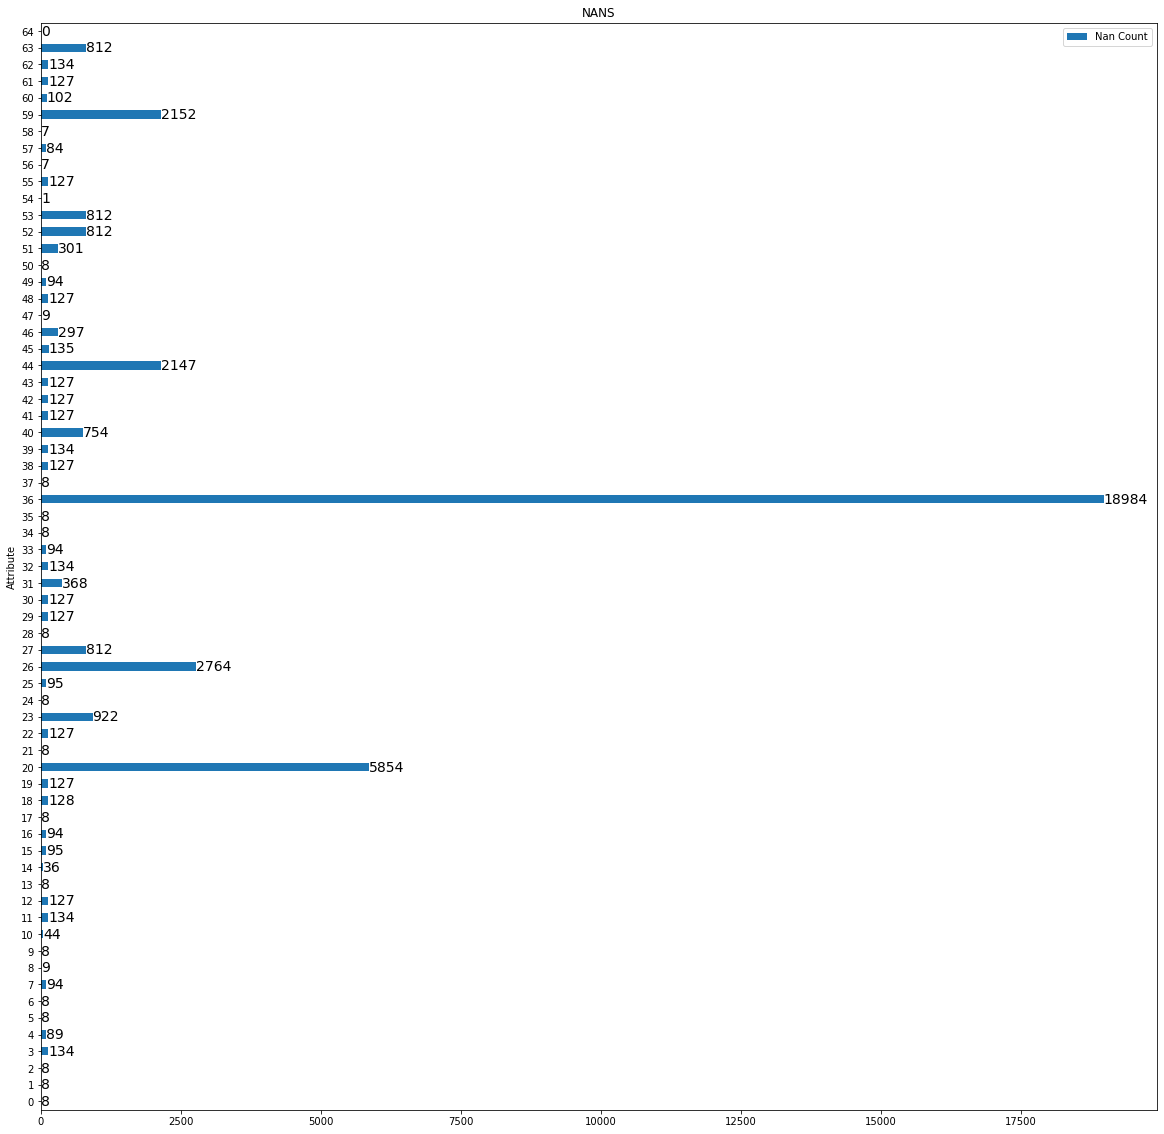

In [5]:
# Checking missing values 
nan_columns = []
nan_values = []

for column in df.columns:
    nan_columns.append(column)
    nan_values.append(df[column].isnull().sum())
    
nan_dict = {'Attributes': nan_columns, "Nan Count": nan_values}
nan_df = pd.DataFrame(nan_dict)

ax = nan_df.plot(kind='barh', stacked=True, figsize=(20, 20), rot=0, xlabel='Attribute', ylabel='Count', title = 'NANS')
for c in ax.containers:
    ax.bar_label(c, label_type='edge', fontsize = 14)

In [12]:
# Now fill all missing values with the mean of the column 
df = df.where(pd.notna(df), df.interpolate(), axis="columns")

In [13]:
# After filling th missing values, check it again.
missing = df.isnull().any(axis=1).sum()
len_before = df.shape[0]
print(f"Total records missing data: {missing}\n"
      f"Total percent of incomplete records: {missing/len_before*100:.2f}%"
     )

Total records missing data: 0
Total percent of incomplete records: 0.00%


## Evaluate and transform to binary 0 0r 1 the target

In [8]:
df["class"].unique


<bound method Series.unique of 0        b'0'
1        b'0'
2        b'0'
3        b'0'
4        b'0'
         ... 
43400    b'1'
43401    b'1'
43402    b'1'
43403    b'1'
43404    b'1'
Name: class, Length: 43405, dtype: object>

In [14]:
# This show that the target is very inbalanced
df['class'].value_counts(normalize=False)

0    41314
1     2091
Name: class, dtype: int64

(array([41314.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2091.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

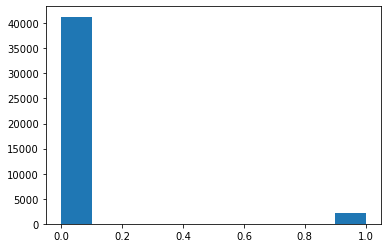

In [15]:
# Plot to better show the inbalanced target
plt.hist(df['class'])

In [16]:
# Convert the target in 0 an1

# classes = []

# for index, row in df.iterrows():
#     class_val = row['class']
#     if class_val not in classes:
#         classes.append(class_val)

# class_dict = {}

# for index, i in enumerate(classes):
#     class_dict.update({i:str(index)})
    
# df['class'] = df['class'].map(class_dict)

# All of the code above can be replaced with this
df['class'] = df['class'].replace([b'0',b'1'],[0,1])

df['class'].unique()

array([0, 1])

In [ ]:
%%time
#Check all correlations
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# show the heatmap
sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(18, 9))
chart=sns.heatmap(df.corr(), cmap=cmap, annot=False)
chart.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
f.tight_layout()

In [ ]:
#List all the top correlations
sort_corr = pd.DataFrame(abs(df.corr().unstack().sort_values().drop_duplicates()))
sort_corr.rename(columns={0:'Top Abs Corr'}, inplace=True)
sort_corr.head(15)

In [17]:
# Dataframe
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


## Explore the differents columns of the data with pandas profiling

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)
profile.to_file(output_file="output.html")

(array([4.3395e+04, 4.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-1325. ,  1798.2,  4921.4,  8044.6, 11167.8, 14291. , 17414.2,
        20537.4, 23660.6, 26783.8, 29907. ]),
 <BarContainer object of 10 artists>)

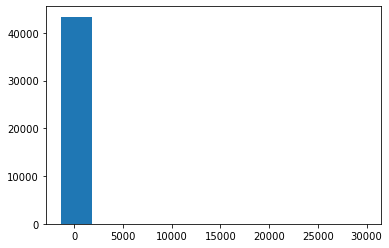

In [18]:
# Sales (n) / sales (n-1)
plt.hist(df["Attr21"])

(array([4.3382e+04, 1.2000e+01, 6.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  -525.52 ,  39419.032,  79363.584, 119308.136, 159252.688,
        199197.24 , 239141.792, 279086.344, 319030.896, 358975.448,
        398920.   ]),
 <BarContainer object of 10 artists>)

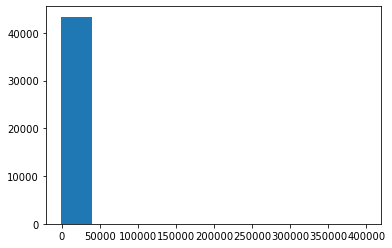

In [19]:
# Profit on operating activities / financial expenses
plt.hist(df["Attr37"])

In [20]:
# Final dataframe
df= df.drop(["Attr21"], axis = 1)
df= df.drop(["Attr37"], axis = 1)
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


# Model preparation

Which methods are you proposing to utilize to solve the problem?  Why is this method appropriate given the business objective? How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?  More specifically, what evaluation metrics are most useful given that the problem is a binary-classification one (ex., Accuracy, F1-score, Precision, Recall, AUC, etc.)?

## Randon Forest

In [21]:
# prepare test and train data

X = df.loc[:, df.columns != 'class'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [22]:
# Impute

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

# Normalize the data
transformer = RobustScaler().fit(X_train)
transformer = RobustScaler().fit(X_test)
X_train = transformer.transform(X_train)
X_test= transformer.transform(X_test)

# Model building and Evaluation

In this case, your primary task is to build both a Random Forest and XGBoost model to accurately predict bankruptcy and will involve the following steps:

- Specify your sampling methodology
- Setup your models - highlighting any important parameters
- Analyze each model's performance - referencing your chosen evaluation metric (including supplemental visuals and analysis where appropriate)

## Set up the Grid Search for Random Forest

In [23]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


RandomizedSearchCV took 433.82 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.960 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.959 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_split': 9}

Model with rank: 3
Mean validation score: 0.958 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3}

GridSearchCV took 767.99 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.961 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.961 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth':

## Evaluation of the model

In [24]:
y_hat_rf_train = grid_search.predict(X_train)
accuracy_score(y_hat_rf_train, y_train)

1.0

In [25]:
# Confusion matrix train
confusion_matrix(y_train, y_hat_rf_train)

array([[27711,     0],
       [    0,  1370]])

In [26]:
y_hat_rf_test = grid_search.predict(X_test)
accuracy_score(y_hat_rf_test, y_test)

0.9579028204412176

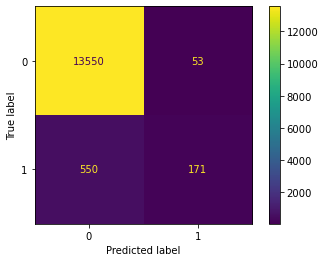

In [27]:
# Confusion matrix test
confusion_matrix(y_test, y_hat_rf_test)
disp = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)

In [32]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label=1, average='binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label=1, average='binary'))

Recall: 0.23717059639389737
Precision: 0.7633928571428571


## Plot evaluation

/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

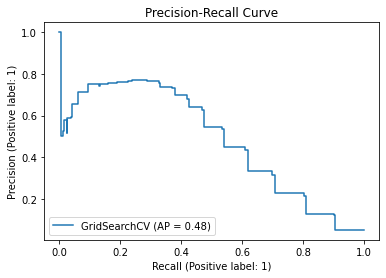

In [33]:
disp = plot_precision_recall_curve(grid_search, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

## ROC

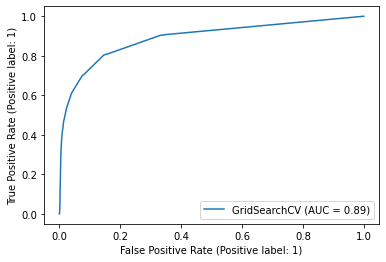

In [34]:
Disp = RocCurveDisplay.from_estimator(grid_search, X_test, y_test)

## XGBoost model

In [35]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate= 0.1,
    max_depth=10, random_state=0).fit(X_train, y_train)

## Evaluation of the model for comparison to random forest, in order to see if we can improve the Random forest best model

In [36]:
clf.score(X_train, y_train)

0.9999656132870259

In [37]:
clf.score(X_test, y_test)

0.9669086847249372

In [38]:
clf.feature_importances_

array([0.00588461, 0.00388707, 0.00847581, 0.01232618, 0.07184301,
       0.01163737, 0.00196333, 0.003059  , 0.01071415, 0.00420449,
       0.00755806, 0.00612147, 0.00900934, 0.00183486, 0.00934689,
       0.02706255, 0.0031658 , 0.00169224, 0.01615013, 0.01577424,
       0.0323057 , 0.00432303, 0.03356255, 0.0106697 , 0.01294828,
       0.06790403, 0.00789072, 0.01712466, 0.01461283, 0.00638914,
       0.0048836 , 0.00820563, 0.09994278, 0.01519958, 0.01336868,
       0.00939099, 0.02327444, 0.02299042, 0.01275292, 0.02007186,
       0.00720668, 0.02977955, 0.01062394, 0.04830489, 0.00973412,
       0.01164038, 0.00820543, 0.00875002, 0.00717586, 0.00417336,
       0.00631805, 0.00742302, 0.01710581, 0.02898069, 0.01081335,
       0.05251332, 0.00862735, 0.00965667, 0.02248084, 0.00572372,
       0.00626327, 0.00897753])

In [39]:
y_hat_G = clf.predict(X_test)

In [41]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_G, pos_label= 1, average='binary'))
print("Precision:", precision_score(y_test, y_hat_G, pos_label= 1, average='binary'))

Recall: 0.4119278779472954
Precision: 0.8559077809798271


## Plot precision and recall

/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

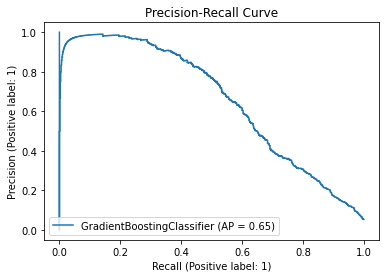

In [42]:
disp = plot_precision_recall_curve(clf, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

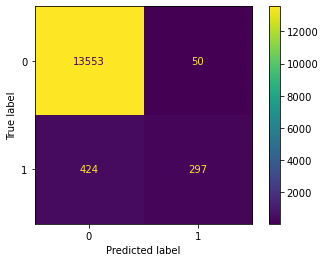

In [43]:
# Confusion matrix
confusion_matrix(y_test, y_hat_G)
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

## ROC 

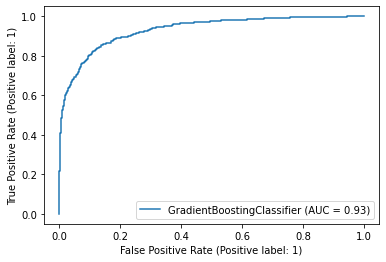

In [44]:
isp = RocCurveDisplay.from_estimator(clf, X_test, y_test)

## Try the grid search for XGBoost in order to see if there is any improvement

In [46]:
param_test1 = {'n_estimators':range(100, 500, 1000),
'max_depth':range(10,16), 'min_samples_split':range(1, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf= 1,random_state= 0), 
param_grid = param_test1,n_jobs=4).fit(X_train, y_train)
gsearch1.score(X_test, y_test)

/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 596, in fit
    monitor,
  File "/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 

0.9678860653448758

In [48]:
y_hat_GG = gsearch1.predict(X_test)
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_GG, pos_label=1, average='binary'))
print("Precision:", precision_score(y_test, y_hat_GG, pos_label= 1, average='binary'))

Recall: 0.42441054091539526
Precision: 0.8717948717948718


# Model Interpretability & Explainability

Using at least one of your models above (if multiple were trained):

- Which variable(s) was (were) "most important" and why?  How did you come to the conclusion and how should your audience interpret this?

In [45]:
# yellow brick

# Set xyz to the appropriate variable
viz = FeatureImportances(xyz, topn=6, relative=False)
viz.fit(X_test, y_test)
viz.show()

NameError: name 'FeatureImportances' is not defined

# Conclusion

After all of your technical analysis and modeling; what are you proposing to your audience and why?  How should they view your results and what should they consider when moving forward?  Are there other approaches you'd recommend exploring?  This is where you "bring it all home" in language they understand.